# Robust Kalman filtering for vehicle tracking

We will try to pinpoint the location of a moving vehicle with high accuracy from noisy sensor data. We'll do this by modeling the vehicle state as a discrete-time linear dynamical system. Standard **Kalman filtering** can be used to approach this problem when the sensor noise is assumed to be Gaussian. We'll use **robust Kalman filtering** to get a more accurate estimate of the vehicle state for a non-Gaussian case with outliers.

# Problem statement
 
A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \mathbf{R}^n$, indexed by time $t \in \lbrace 0, \ldots, N-1 \rbrace$ and dynamics equations

\begin{align}
x_{t+1} &= Ax_t + Bw_t\\
y_t &=Cx_t + v_t,
\end{align}

where $w_t \in \mathbf{R}^m$ is an input to the dynamical system (say, a drive force on the vehicle), $y_t \in \mathbf{R}^r$ is a state measurement, $v_t \in \mathbf{R}^r$ is noise, $A$ is the drift matrix, $B$ is the input matrix, and $C$ is the observation matrix.

Given $A$, $B$, $C$, and $y_t$ for $t = 0, \ldots, N-1$, the goal is to estimate $x_t$ for $t = 0, \ldots, N-1$.

# Kalman filtering

A Kalman filter estimates $x_t$ by solving the optimization problem

\begin{array}{ll}
\mbox{minimize} & \sum_{t=0}^{N-1} \left( 
\|w_t\|_2^2 + \tau \|v_t\|_2^2\right)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bw_t,\quad t=0,\ldots, N-1\\
& y_t = Cx_t+v_t,\quad t = 0, \ldots, N-1,
\end{array}

where $\tau$ is a tuning parameter. This problem is actually a least squares problem, and can be solved via linear algebra, without the need for more general convex optimization. Note that since we have no observation $y_{N}$, $x_N$ is only constrained via $x_{N} = Ax_{N-1} + Bw_{N-1}$, which is trivially resolved when $w_{N-1} = 0$ and $x_{N} = Ax_{N-1}$. We maintain this vestigial constraint only because it offers a concise problem statement.

This model performs well when $w_t$ and $v_t$ are Gaussian. However, the quadratic objective can be influenced by large outliers, which degrades the accuracy of the recovery. To improve estimation in the presence of outliers, we can use **robust Kalman filtering**.

# Robust Kalman filtering

To handle outliers in $v_t$, robust Kalman filtering replaces the quadratic cost with a Huber cost, which results in the convex optimization problem

\begin{array}{ll}
\mbox{minimize} & \sum_{t=0}^{N-1} \left( \|w_t\|^2_2 + \tau \phi_\rho(v_t) \right)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bw_t,\quad t=0,\ldots, N-1\\
& y_t = Cx_t+v_t,\quad t=0,\ldots, N-1,
\end{array}

where $\phi_\rho$ is the Huber function
$$
\phi_\rho(a)= \left\{ \begin{array}{ll} \|a\|_2^2 & \|a\|_2\leq \rho\\
2\rho \|a\|_2-\rho^2 & \|a\|_2>\rho.
\end{array}\right.
$$

The Huber penalty function penalizes estimation error linearly outside of a ball of radius $\rho$, whereas in standard Kalman filtering, all errors are penalized quadratically. Thus, large errors are penalized less harshly, making this model more robust to outliers.

# Vehicle tracking example

We'll apply standard and robust Kalman filtering to a vehicle tracking problem with state $x_t \in \mathbf{R}^4$, where
$(x_{t,0}, x_{t,1})$ is the position of the vehicle in two dimensions, and $(x_{t,2}, x_{t,3})$ is the vehicle velocity.
The vehicle has unknown drive force $w_t$, and we observe noisy measurements of the vehicle's position, $y_t \in \mathbf{R}^2$.

The matrices for the dynamics are

$$
A = \begin{bmatrix}
1 & 0 & \left(1-\frac{\gamma}{2}\Delta t\right) \Delta t & 0 \\
0 & 1 & 0 & \left(1-\frac{\gamma}{2} \Delta t\right) \Delta t\\
0 & 0 & 1-\gamma \Delta t & 0 \\
0 & 0 & 0 & 1-\gamma \Delta t
\end{bmatrix},
$$

$$
B = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0 \\
0 & \frac{1}{2}\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t \\
\end{bmatrix},
$$

$$
C = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix},
$$
where $\gamma$ is a velocity damping parameter.

# 1D Model
The recurrence is derived from the following relations in a single dimension. For this subsection, let $x_t, v_t, w_t$ be the vehicle position, velocity, and input drive force. The resulting acceleration of the vehicle is $w_t - \gamma v_t$, with $- \gamma v_t$ is a damping term depending on velocity with parameter $\gamma$. 

The discretized dynamics are obtained from numerically integrating:
$$
\begin{align}
x_{t+1} &= x_t + \left(1-\frac{\gamma \Delta t}{2}\right)v_t \Delta t + \frac{1}{2}w_{t} \Delta t^2\\
v_{t+1} &= \left(1-\gamma\right)v_t + w_t \Delta t.
\end{align}
$$

Extending these relations to two dimensions gives us the dynamics matrices $A$ and $B$.

## Helper Functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot_state(t,actual, estimated=None):
    '''
    plot position, speed, and acceleration in the x and y coordinates for
    the actual data, and optionally for the estimated data
    '''
    trajectories = [actual]
    if estimated is not None:
        trajectories.append(estimated)
        
    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8,8))
    for x, w in trajectories:  
        ax[0,0].plot(t,x[0,:-1])
        ax[0,1].plot(t,x[1,:-1])
        ax[1,0].plot(t,x[2,:-1])
        ax[1,1].plot(t,x[3,:-1])
        ax[2,0].plot(t,w[0,:])
        ax[2,1].plot(t,w[1,:])
        
    ax[0,0].set_ylabel('x position')
    ax[1,0].set_ylabel('x velocity')
    ax[2,0].set_ylabel('x input')
    
    ax[0,1].set_ylabel('y position')
    ax[1,1].set_ylabel('y velocity')
    ax[2,1].set_ylabel('y input')
    
    ax[0,1].yaxis.tick_right()
    ax[1,1].yaxis.tick_right()
    ax[2,1].yaxis.tick_right()
    
    ax[0,1].yaxis.set_label_position("right")
    ax[1,1].yaxis.set_label_position("right")
    ax[2,1].yaxis.set_label_position("right")
    
    ax[2,0].set_xlabel('time')
    ax[2,1].set_xlabel('time')

def plot_positions(traj, labels, axis=None,filename=None):
    '''
    show point clouds for true, observed, and recovered positions
    '''
    matplotlib.rcParams.update({'font.size': 14})
    n = len(traj)

    fig, ax = plt.subplots(1, n, sharex=True, sharey=True,figsize=(12, 5))
    if n == 1:
        ax = [ax]
    
    for i,x in enumerate(traj):
        ax[i].plot(x[0,:], x[1,:], 'ro', alpha=.1)
        ax[i].set_title(labels[i])
        if axis:
            ax[i].axis(axis)
    
    if filename:
        fig.savefig(filename, bbox_inches='tight')

## Problem Data

We generate the data for the vehicle tracking problem. We'll have $N=1000$, $w_t$ a standard Gaussian, and $v_t$ a standard Guassian, except $20\%$ of the points will be outliers with $\sigma = 20$.

Below, we set the problem parameters and define the matrices $A$, $B$, and $C$.

In [2]:
n = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts, delt = np.linspace(0,T,n,endpoint=True, retstep=True)
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

C[0,0] = 1
C[1,1] = 1

# Simulation

We seed $x_0 = 0$ (starting at the origin with zero velocity) and simulate the system forward in time. The results are the true vehicle positions `x_true` (which we will use to judge our recovery) and the observed positions `y`.

We plot the position, velocity, and system input $w$ in both dimensions as a function of time.
We also plot the sets of true and observed vehicle positions.

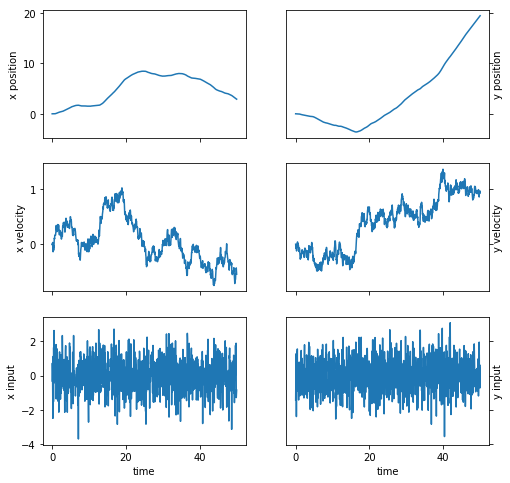

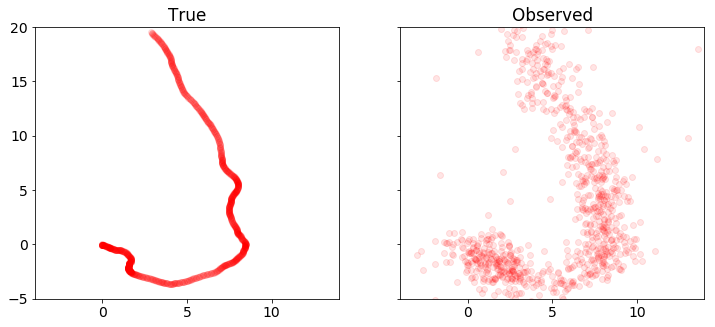

In [3]:
sigma = 20
p = .20
np.random.seed(6)

x = np.zeros((4,n+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,n))

# generate random input and noise vectors
w = np.random.randn(2,n)
v = np.random.randn(2,n)

# add outliers to v
np.random.seed(0)
inds = np.random.rand(n) <= p
v[:,inds] = sigma*np.random.randn(2,n)[:,inds]

# simulate the system forward in time
for t in range(n):
    y[:,t] = C.dot(x[:,t]) + v[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    
x_true = x.copy()
w_true = w.copy()

plot_state(ts,(x_true,w_true))
plot_positions([x_true,y], ['True', 'Observed'],[-4,14,-5,20],'rkf1.pdf')

# Kalman filtering recovery

The code below solves the standard Kalman filtering problem using CVXPY. We plot and compare the true and recovered vehicle states. Note that the recovery is distorted by outliers in the measurements.

-----------------------------------------------------------------
           OSQP v0.4.1  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 8004, constraints m = 6000
          nnz(P) + nnz(A) = 22000
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   6.14e+01   6.14e+03   1.00e-01   1.28e-02s
  50   1.1057e+04   3.57e-07   8.27e-08   1.00e-01   3.01e-02s
plsh   1.1057e+04   7.11e-15   1.24e-14   --------   3.78e-

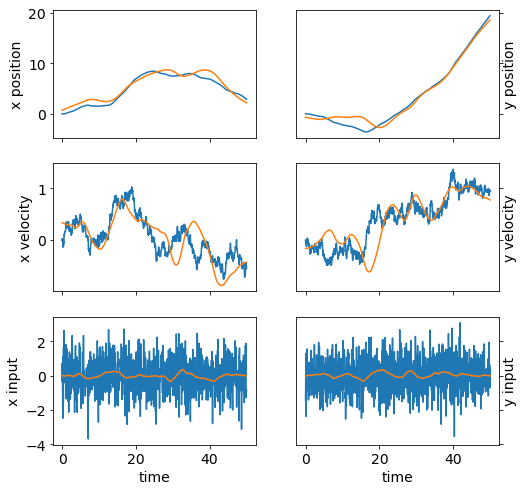

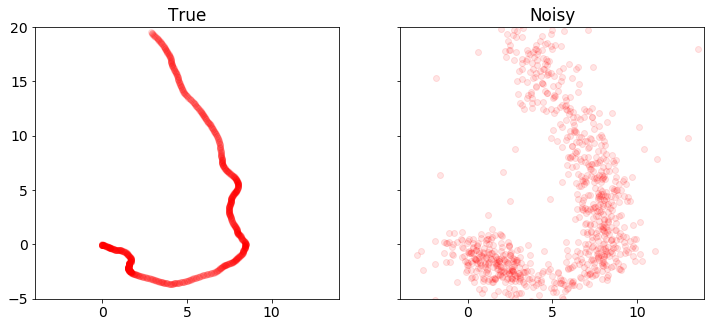

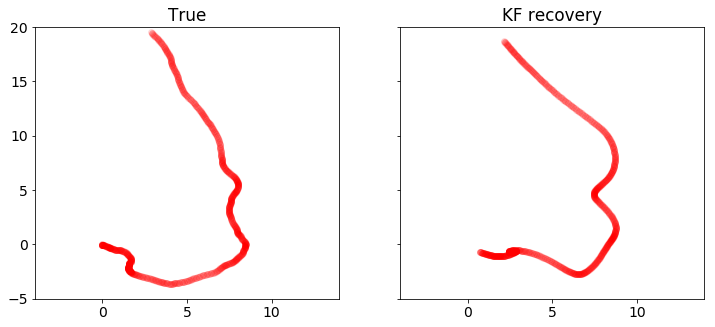

In [4]:
%%time
import cvxpy as cp

x = cp.Variable(shape=(4, n+1))
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = .08
    
obj = cp.sum_squares(w) + tau*cp.sum_squares(v)
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A*x[:,t] + B*w[:,t] ,
                y[:,t]   == C*x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x = np.array(x.value)
w = np.array(w.value)

plot_state(ts,(x_true,w_true),(x,w))
plot_positions([x_true,y], ['True', 'Noisy'], [-4,14,-5,20])
plot_positions([x_true,x], ['True', 'KF recovery'], [-4,14,-5,20], 'rkf2.pdf')

print("optimal objective value: {}".format(obj.value))

# Robust Kalman filtering recovery

Here we implement robust Kalman filtering with CVXPY. We get a better recovery than the standard Kalman filtering, which can be seen in the plots below.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.923e+02  +7e+05  3e-01  3e-02  1e+00  2e+02    ---    ---    1  1  - |  -  - 
 1  +5.090e+02  +4.360e+02  +2e+05  4e-01  1e-02  3e+01  6e+01  0.8051  2e-01   2  1  1 |  0  0
 2  +4.188e+03  +4.134e+03  +2e+05  3e-01  9e-03  3e+01  5e+01  0.4259  6e-01   1  1  1 |  0  0
 3  +9.956e+03  +9.923e+03  +1e+05  3e-01  8e-03  4e+01  4e+01  0.5830  5e-01   1  1  2 |  0  0
 4  +1.881e+04  +1.880e+04  +7e+04  3e-01  5e-03  3e+01  2e+01  0.7189  3e-01   1  1  1 |  0  0
 5  +2.572e+04  +2.572e+04  +4e+04  2e-01  3e-03  2e+01  1e+01  0.5464  3e-01   1  1  1 |  0  0
 6  +2.986e+04  +2.985e+04  +3e+04  2e-01  2e-03  1e+01  6e+00  0.5716  3e-01   2  2  1 |  0  0
 7  +3.262e+04  +3.262e+04  +1e+04  9e-02  1e-03  7e+00  3e+00  0.6007  2e-01   2  2  2 |  0  0
 8  +3.425e+04  +3.425e+04  +8e+03  5e-02  7e-

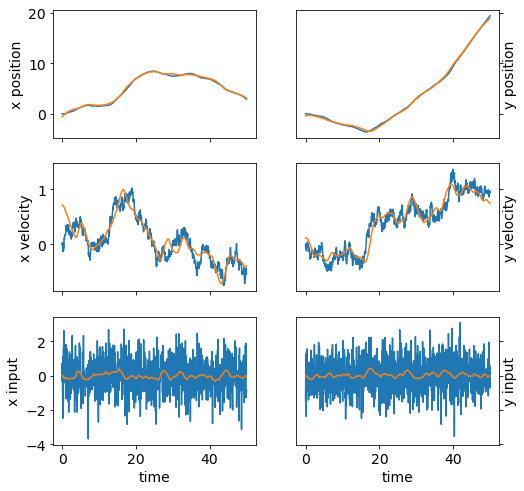

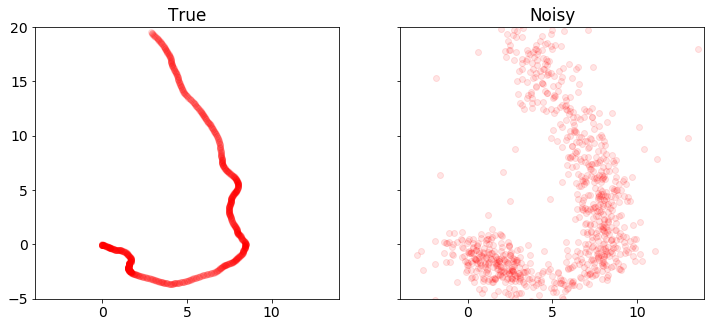

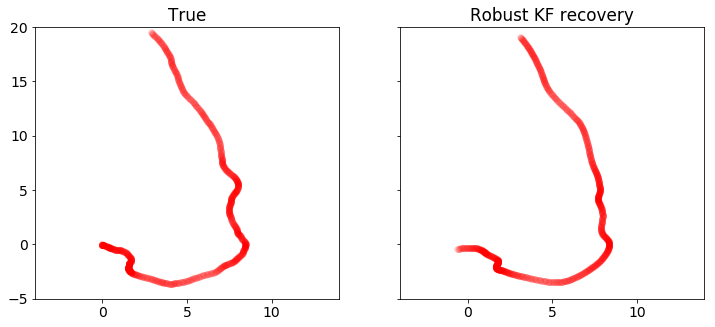

In [5]:
%%time
import cvxpy as cp

x = cp.Variable(shape=(4, n+1))
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = 2
rho = 2
    
obj = cp.sum_squares(w)
obj += cp.sum([tau*cp.huber(cp.norm(v[:,t]),rho) for t in range(n)])
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A*x[:,t] + B*w[:,t] ,
                y[:,t]   == C*x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x = np.array(x.value)
w = np.array(w.value)

plot_state(ts,(x_true,w_true),(x,w))
plot_positions([x_true,y], ['True', 'Noisy'], [-4,14,-5,20])
plot_positions([x_true,x], ['True', 'Robust KF recovery'], [-4,14,-5,20],'rkf3.pdf')

print("optimal objective value: {}".format(obj.value))